In [2]:
import importlib.util
import sys
import pandas as pd
import subprocess
import os
import scanpy as sc
import contextlib
import io
from scipy.sparse import csr_matrix
from scdiff2.scdiff2 import Cell,Graph
from tqdm import tqdm

from anndata import AnnData
from scipy.sparse import csr_matrix
'''
spec = importlib.util.spec_from_file_location("scdiff2_init", "/ocean/projects/hmcmutc/qsong/projects/Fast-CSHMM/scdiff2_init.py")
scdiff2_init = importlib.util.module_from_spec(spec)
sys.modules["scdiff2_init"] = scdiff2_init
spec.loader.exec_module(scdiff2_init)
'''
spec = importlib.util.spec_from_file_location("CSHMM_analysis", "/ocean/projects/hmcmutc/qsong/projects/Fast-CSHMM/CSHMM_analysis.py")
CSHMM_analysis = importlib.util.module_from_spec(spec)
sys.modules["CSHMM_analysis"] = CSHMM_analysis
spec.loader.exec_module(CSHMM_analysis)

## Initilialize CSHMM model with scdiff2

**step 1. Initialize data objects (with clustering results from Seurat)**

In [2]:
expr_WT = pd.read_csv("/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/expression_WT",sep = "\t")
expr_GATA6 = pd.read_csv("/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/expression_GATA6",sep = "\t")

In [3]:
obs_WT = pd.DataFrame(expr_WT.iloc[:,:4].values,
                      columns = ["cell_id","time","label","cluster"],
                      index = expr_WT.iloc[:,0].values
                     )

obs_GATA6 = pd.DataFrame(expr_GATA6.iloc[:,:4].values,
                         columns = ["cell_id","time","label","cluster"],
                         index = expr_GATA6.iloc[:,0].values
                        )

var_WT = pd.DataFrame(expr_WT.columns[4:],index = expr_WT.columns[4:], columns = ["feature_name"])
var_GATA6 = pd.DataFrame(expr_GATA6.columns[4:],index = expr_GATA6.columns[4:], columns = ["feature_name"])

In [4]:
ann_WT = AnnData(csr_matrix(expr_WT.iloc[:,4:].values), obs = obs_WT, var = var_WT)
ann_GATA6 = AnnData(csr_matrix(expr_GATA6.iloc[:,4:].values), obs = obs_GATA6, var = var_GATA6)

filtering and normalization

In [5]:
sc.pp.filter_cells(ann_WT,min_genes=200)
sc.pp.filter_genes(ann_WT,min_cells=3)

sc.pp.filter_cells(ann_GATA6,min_genes=200)
sc.pp.filter_genes(ann_GATA6,min_cells=3)

sc.pp.normalize_total(ann_WT, target_sum=1e4)
sc.pp.log1p(ann_WT)

sc.pp.normalize_total(ann_GATA6, target_sum=1e4)
sc.pp.log1p(ann_GATA6)

get hvg

In [6]:
sc.pp.highly_variable_genes(ann_WT, min_mean=0.0125, max_mean=5, min_disp=0.15)
sc.pp.highly_variable_genes(ann_GATA6, min_mean=0.0125, max_mean=5, min_disp=0.15)
ann_WT = ann_WT[:, ann_WT.var["highly_variable"]]
ann_GATA6 = ann_GATA6[:, ann_GATA6.var["highly_variable"]]

Use directly the cluster labels from seurat clustering

In [7]:
ann_WT.obs["day_cluster"] = ann_WT.obs["time"].astype("string").str.cat(ann_WT.obs["cluster"].astype("string"),sep = "_")
ann_GATA6.obs["day_cluster"] = ann_GATA6.obs["time"].astype("string").str.cat(ann_GATA6.obs["cluster"].astype("string"),sep = "_")

In [8]:
cls = ann_WT.obs["day_cluster"].unique()
for idx,cl in enumerate(cls):
    ann_WT.obs.loc[ann_WT.obs["day_cluster"] == cl,"day_cluster"] = str(idx)

In [9]:
cls = ann_GATA6.obs["day_cluster"].unique()
for idx,cl in enumerate(cls):
    ann_GATA6.obs.loc[ann_GATA6.obs["day_cluster"] == cl,"day_cluster"] = str(idx)

Specify the root cluster for scdiff2

In [10]:
root_WT = ann_WT.obs.loc[(ann_WT.obs["time"] == 0) & (ann_WT.obs["cluster"] == 0),]["day_cluster"].unique()[0]
root_GATA6 = ann_GATA6.obs.loc[(ann_GATA6.obs["time"] == 0.5) & (ann_GATA6.obs["cluster"] == 0),]["day_cluster"].unique()[0]

Get PAGA tree

In [11]:
sc.tl.pca(ann_WT, svd_solver='arpack')
sc.tl.pca(ann_GATA6, svd_solver='arpack')
sc.pp.neighbors(ann_WT, n_neighbors=15, n_pcs=50)
sc.pp.neighbors(ann_GATA6, n_neighbors=15, n_pcs=50)
sc.tl.paga(ann_WT, groups = 'day_cluster')
sc.tl.paga(ann_GATA6, groups = 'day_cluster')

**step 2. Run scdiff2 main steps**

In [12]:
def run_scidiff2(prRes, rootnodeID, tfdna_file, MAXLOOP = 5, fChangeCut=0.6, llhcut=0.05, pval_cut=0.05, ncores=2):
    
    print("Generating graph with scdiff2...")
    # Genes
    GL=[item.upper() for item in prRes.var.index]
    tfList = None
    
    # clusters
    clusters=prRes.obs['day_cluster']

    # paga connectivity
    clusterIDs=sorted([int(item) for item in list(clusters.unique())])
    pagaConnects=pd.DataFrame(data=prRes.uns['paga']['connectivities_tree'].toarray())
    pagaConnects.index=clusterIDs
    pagaConnects.columns=clusterIDs

    # list to store all cells
    AllCells=[]

    for i in range(len(prRes.obs.index)):
        iid=prRes.obs.index[i]
        ti=float(prRes.obs.time[i])
        li=prRes.obs.label[i]
        ei=prRes.X[i,:]
        ci=Cell(iid,ti,ei,li)
        AllCells.append(ci)

    #load clusters from the prerun results
    clusters = prRes.obs['day_cluster']
    
    #Build graph (contextlib.redirect_stdout suppresses the output)
    with contextlib.redirect_stdout(io.StringIO()):
        G1 = Graph(AllCells,tfdna_file,tfList,GL,clusters,pagaConnects,rootnodeID=rootnodeID,fChangeCut=fChangeCut,ncores=ncores)
    print("Done")
    
    # if MAXLOOP (iterative refinment), calculate the inital llh
    if MAXLOOP > 0:
        with contextlib.redirect_stdout(io.StringIO()):
            G1.llh=G1.getLikelihood(ncores) # old likelihood
        ollh=G1.llh
        ILLH=ollh     # initial LLH
    
    # Main loops for scdiff2
    print("Performing PGM refinement...")
    for loop in tqdm(range(MAXLOOP)):

        with contextlib.redirect_stdout(io.StringIO()):
            nllh=G1.ReAssign(ncores)
        G1.llh=nllh
        increase_llh=(nllh-ollh)/abs(ILLH)

        # log iterative refinment
        with contextlib.redirect_stdout(io.StringIO()):
            prRes=G1.updateGraph(prRes,ncores)
        if increase_llh<llhcut:
            break
        ollh=nllh      # update ollh<-nllh

    # Get etfs from each path. Keep only the etfs with pval <= pval_cut
    uniq_path_etf = dict()
    for _ in G1.Paths:
        for path in _:
            ind_p = G1.Nodes.index(path.fromNode)
            ind_c = G1.Nodes.index(path.toNode)
            if (ind_p, ind_c) not in uniq_path_etf:
                uniq_path_etf[(ind_p, ind_c)] = [[tf,pval] for pval,tf in path.etf if pval <= pval_cut]

    # Collect scdiff2 tree node pairs, cell node pairs, and etfs for each path.
    node_pairs = []
    cell_node_pairs = []
    path_etfs = []
    path_etfs_pval = []
    for node in G1.Nodes:

        # Get index of the current node
        ind_c = G1.Nodes.index(node)

        # Get index of the parent node of the current node.
        if node.P is not None:
            ind_p = G1.Nodes.index(node.P)
            node_pairs.append(f"{str(ind_p)} {str(ind_c)}")
            path_etfs.append(",".join([each[0] for each in uniq_path_etf[(ind_p, ind_c)]]))
            path_etfs_pval.append(",".join([str(each[1]) for each in uniq_path_etf[(ind_p, ind_c)]]))

        for cell in node.cells:
            cell_node_pairs.append(f"{str(cell.ID)} {str(ind_c)}")
    
    print("Done")
    return node_pairs,cell_node_pairs,path_etfs,path_etfs_pval

In [ ]:
tfdna_file = "/ocean/projects/hmcmutc/qsong/projects/scdiff2/tf_dna/Human_TF_targets.txt"

node_pairs_GATA6,cell_node_pairs_GATA6,path_etfs_GATA6,path_etf_pval_GATA6 = run_scidiff2(ann_GATA6, rootnodeID = root_GATA6, tfdna_file = tfdna_file, pval_cut = 0.05, ncores=1)

Generating graph with scdiff2...
Done
Performing PGM refinement...


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
node_pairs_WT,cell_node_pairs_WT,path_etfs_WT,path_etf_pval_WT = run_scidiff2(ann_WT, rootnodeID = root_WT, tfdna_file = tfdna_file, pval_cut = 0.05, ncores=92)

In [ ]:
node_pairs_GATA6

In [ ]:
path_etf_tf = dict()
path_etf_pval = dict()
for path,(etf,pval) in path_etfs_WT.items():
    path_etf_tf[path] = etf
    path_etf_pval[path] = pval

Save the results for scdiff2 initialization

In [158]:
file_WT = "/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/structure_file_WT"
file_GATA6 = "/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/structure_file_GATA6"
with open(file_WT,"w") as f:
    f.write("\t".join(node_pairs_WT) + "\n")
    f.write("\t".join(cell_node_pairs_WT) + "\n")
    f.write("\t".join(path_etfs_WT))
    
with open(file_GATA6,"w") as f:
    f.write("\t".join(node_pairs_GATA6) + "\n")
    f.write("\t".join(cell_node_pairs_GATA6) + "\n")
    f.write("\t".join(path_etfs_GATA6))

Remove column 'cluster' and use normalized expressions for CSHMM

In [159]:
del(expr_WT['cluster_WT'])
del(expr_GATA6['cluster_GATA6'])

In [160]:
expr = pd.DataFrame(ann_WT.X.toarray())
meta = expr_WT.iloc[:,:3]
meta.index = meta.iloc[:,0]
meta = meta.loc[ann_WT.obs.index,]
meta.reset_index(inplace=True,drop=True)
cols = ["index","time","label"] + ann_WT.var_names.tolist()
out = pd.concat([meta, expr],axis = 1)
out.columns = cols
out.to_csv("/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/expression_WT",sep = "\t",index = None)

In [161]:
expr = pd.DataFrame(ann_GATA6.X.toarray())
meta = expr_GATA6.iloc[:,:3]
meta.index = meta.iloc[:,0]
meta = meta.loc[ann_GATA6.obs.index,]
meta.reset_index(inplace=True,drop=True)
cols = ["index","time","label"] + ann_GATA6.var_names.tolist()
out = pd.concat([meta, expr],axis = 1)
out.columns = cols
out.to_csv("/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/expression_GATA6",sep = "\t",index = None)

**Step3. Run CSHMM and order cells with trees generated in previous steps**

In [162]:
cmd = ["conda", "run", "-n", "cshmm_env_py37",
"python","/ocean/projects/hmcmutc/qsong/projects/Fast-CSHMM/Fast-CSHMM_train.py",
"--data_file","/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/expression_WT",
"--structure_file","/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/structure_file_WT",
"--n_split","100",
"-ng","4000",
"--n_iteration","5",
"--cross_validation","0",
"--random_seed","0",
"--model_name","/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/cshmm_model_WT",
"--n_jobs","50"]
re = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

In [163]:
cmd = ["conda", "run", "-n", "cshmm_env_py37",
"python","/ocean/projects/hmcmutc/qsong/projects/Fast-CSHMM/Fast-CSHMM_train.py",
"--data_file","/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/expression_GATA6",
"--structure_file","/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/structure_file_GATA6",
"--n_split","100",
"-ng","4000",
"--n_iteration","5",
"--cross_validation","0",
"--random_seed","0",
"--model_name","/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/cshmm_model_GATA6",
"--n_jobs","50"]
re = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

In [2]:
os.chdir("/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/")
model_WT = "cshmm_model_WT_it5.pickle"
model_GATA6 = "cshmm_model_GATA6_it5.pickle"
data_WT = "expression_WT"
data_GATA6 = "expression_GATA6"

plotting path figure for model file:  cshmm_model_WT_it5.pickle
loading model from file:  cshmm_model_WT_it5.pickle
loading data......
3406  cell loaded with  4375  genes selected
structure.png


<Figure size 1000x700 with 0 Axes>

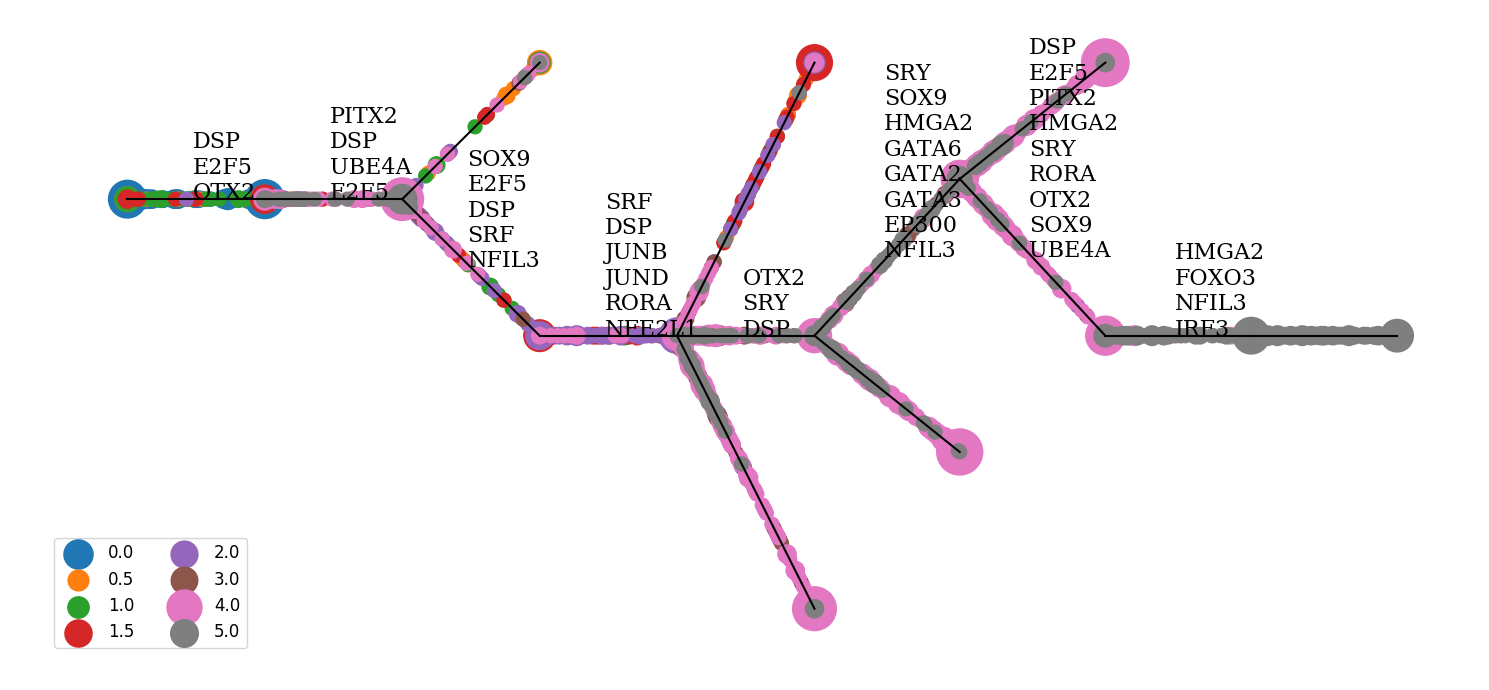

In [35]:
%matplotlib inline
CSHMM_analysis.plot_path_fig(model_WT, data_WT, circle_size=100,color_by="time_point",show_node_label=False,show_path_tf=True)

plotting path figure for model file:  cshmm_model_WT_it5.pickle
loading model from file:  cshmm_model_WT_it5.pickle
loading data......
3406  cell loaded with  4375  genes selected
structure.png


<Figure size 1000x700 with 0 Axes>

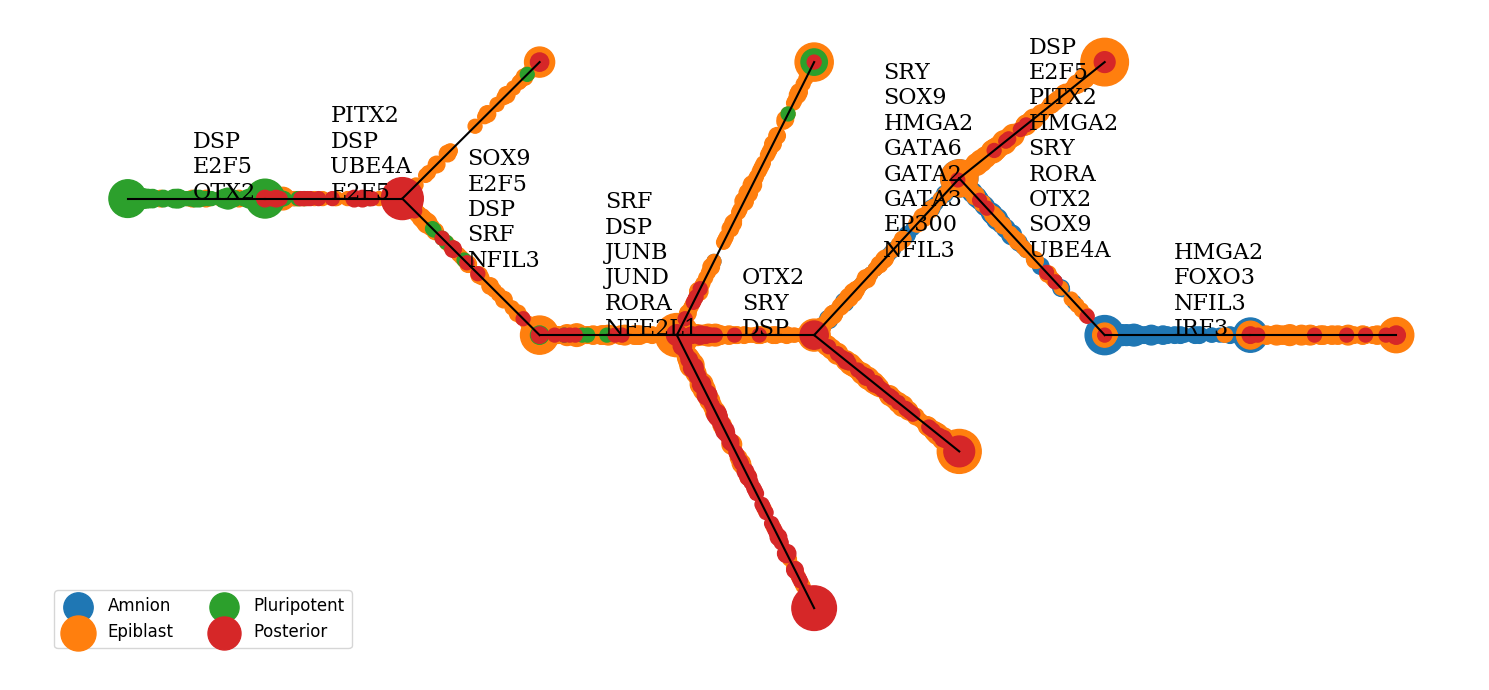

In [36]:
%matplotlib inline
CSHMM_analysis.plot_path_fig(model_WT, data_WT, circle_size=100,color_by="cell_label",show_node_label=False,show_path_tf=True)

plotting path figure for model file:  cshmm_model_GATA6_it5.pickle
loading model from file:  cshmm_model_GATA6_it5.pickle
loading data......
10631  cell loaded with  4754  genes selected
structure.png


<Figure size 1000x700 with 0 Axes>

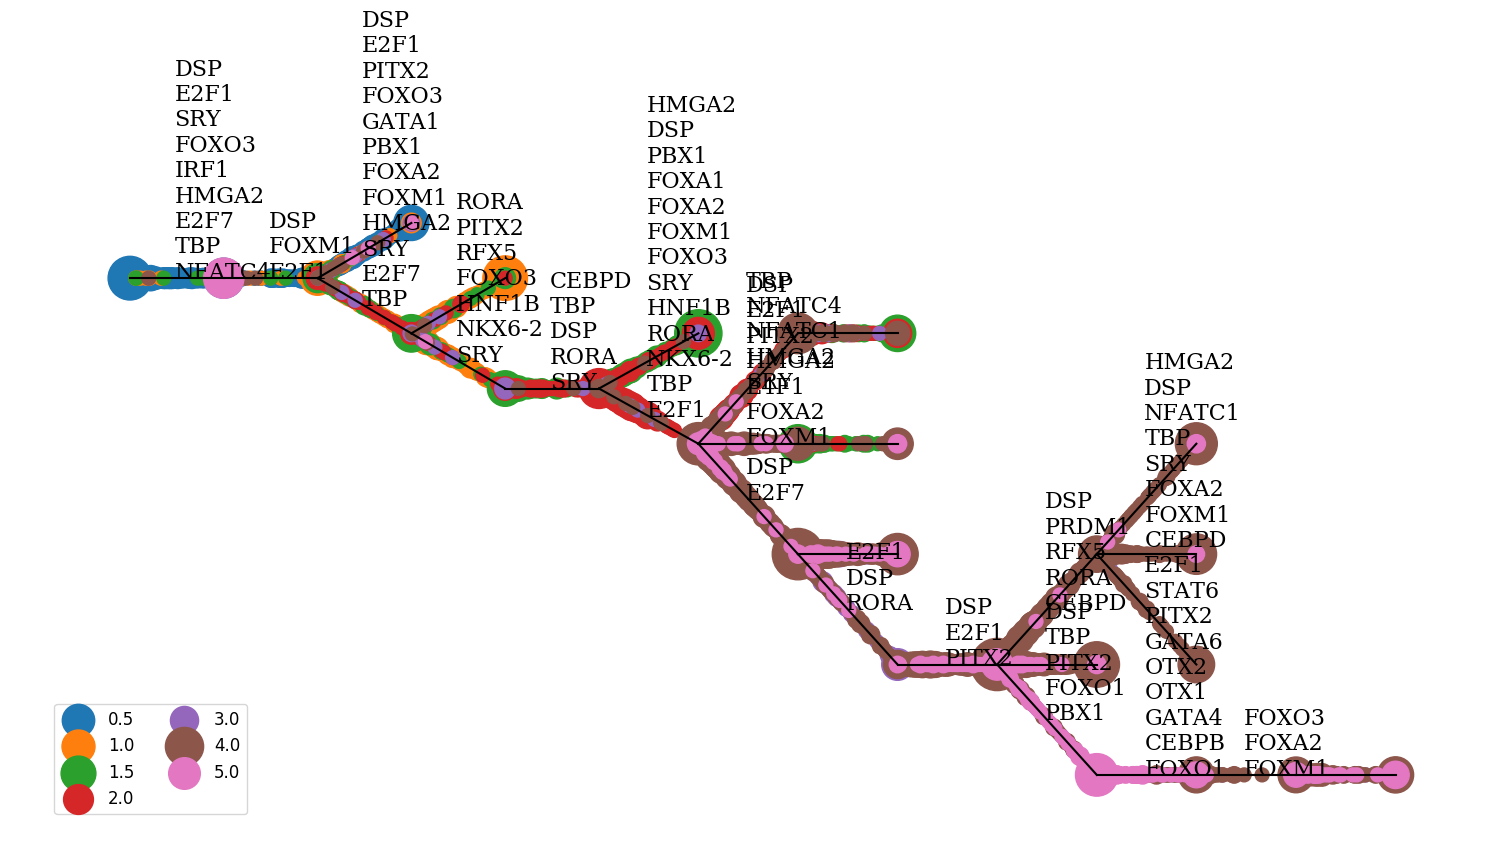

In [34]:
%matplotlib inline
CSHMM_analysis.plot_path_fig(model_GATA6, data_GATA6, circle_size=100,color_by="time_point",show_node_label=False,show_path_tf=True)

plotting path figure for model file:  cshmm_model_GATA6_it5.pickle
loading model from file:  cshmm_model_GATA6_it5.pickle
loading data......
10631  cell loaded with  4754  genes selected
structure.png


<Figure size 1000x700 with 0 Axes>

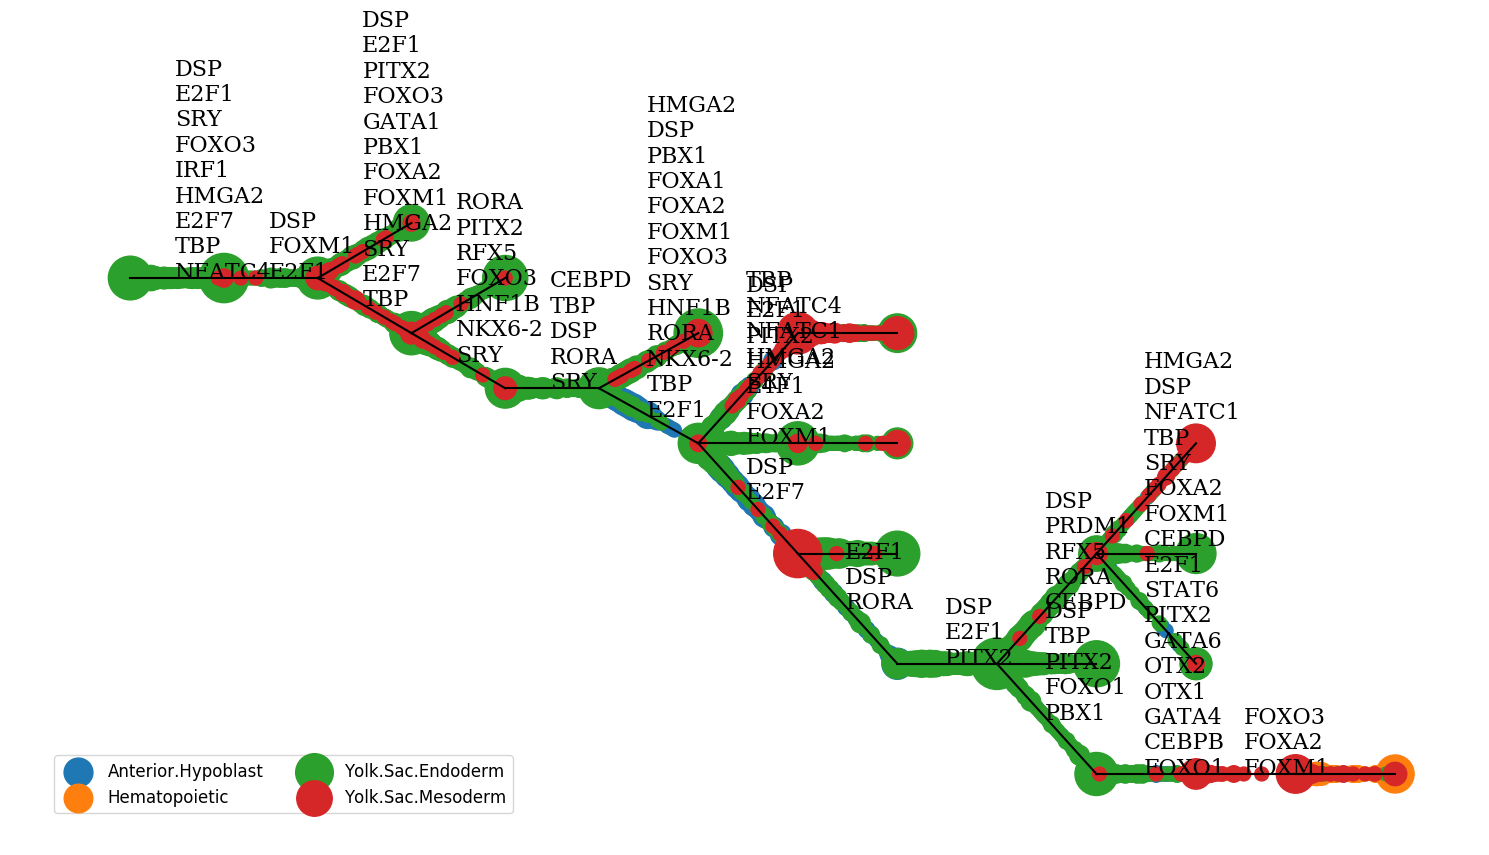

In [37]:
%matplotlib inline
CSHMM_analysis.plot_path_fig(model_GATA6, data_GATA6, circle_size=100,color_by="cell_label",show_node_label=False,show_path_tf=True)

**Step 4 CSHMM trajectory web visulization**

Generate json files

In [10]:
cmd = ["conda", "run", "-n", "cshmm_env_py37",
       "python","/ocean/projects/hmcmutc/qsong/projects/Fast-CSHMM/Fast-CSHMM_make_json.py",
       "/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/expression_WT",
      "/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/cshmm_model_WT_it5.pickle",
       #"/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/scripts/web_visualization_WT/tfdna.json",
      "4000","False"]
res = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

cmd = ["conda", "run", "-n", "cshmm_env_py37",
       "python","/ocean/projects/hmcmutc/qsong/projects/Fast-CSHMM/Fast-CSHMM_make_json.py",
       "/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/expression_GATA6",
      "/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/cshmm_model_GATA6_it5.pickle",
       #"/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/scripts/web_visualization_GATA6/tfdna.json",
      "4000","False"]
res = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

copy .json files to the web_visualization folder and rename them as data.json and CellViz.json.

In [1]:
%%bash
mv /ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/cshmm_model_WT_it5.pickle_data.json \
/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/scripts/web_visualization_WT/data.json
mv /ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/cshmm_model_WT_it5.pickle_CellViz.json \
/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/scripts/web_visualization_WT/CellViz.json

mv /ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/cshmm_model_GATA6_it5.pickle_data.json \
/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/scripts/web_visualization_GATA6/data.json
mv /ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/cshmm_model_GATA6_it5.pickle_CellViz.json \
/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/scripts/web_visualization_GATA6/CellViz.json

Generate .db (database) by runing utils/create_table.py and generate .db file in ht_bin folder.

In [26]:
cmd = [
    "conda","run","-n","cshmm_env_py37",
    "python",
    "web_visualization_WT/utils/create_table.py",
    "/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/scripts/web_visualization_WT/ht-bin/ex1",
    "/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/expression_WT"
]
re = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

cmd = [
    "conda","run","-n","cshmm_env_py37",
    "python",
    "web_visualization_GATA6/utils/create_table.py",
    "/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/scripts/web_visualization_GATA6/ht-bin/ex1",
    "/ocean/projects/hmcmutc/qsong/projects/idiscoid/idiscoid/src/GATA6_R/results/scdiff2/expression_GATA6"
]
re = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

Boot server using simpleServer.py. You may modify the port in `server_address = ("", 5858)`, where 5858 indicates the default port